# Image inpainting problem on CIFAR10

In this notebook I try to implement different nets for solving the same problem.

This was done to fine-tune the networks for optimal performance and to learn the majority of the theoretical concepts covered in the course.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 3s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


In [3]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X


masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))


## Autoencoder for image unpainting

 This neural network is a convolutional autoencoder model. The goal of the convolutional autoencoder is to compress an input image into a low-dimensional representation (often called a "latent code") and then reconstruct the input image from the latent code.
 
 Before the autoencoder we have 2 indipendent convolution blocks in order to learn different features from the input image.
 There is no dense layer as a bottleneck beacuse the dataset is small compared to the size of the net. 

The convolutional autoencoder is composed of two main parts:
1. The encoder consists of a series of convolutional layers that compress the input image into a low-dimensional representation.
2. The decoder, on the other hand, uses a series of deconvolution (or upsampling) layers to reconstruct the input image from the low-dimensional representation.

The neural network shown here begins with a first convolutional layer that uses a 5x5 convolution and a stride of 1. This layer is followed by a set of four convolutional blocks, each consisting of three convolutional layers, a LeakyReLU activation function with an alpha of 0.2, and a batch normalization layer. The LeakyReLu is used in order to prevent the vanishing relu problem. 
These convolutional blocks are designed to extract the features of the input image in order to compress them into a low-dimensional representation.

Subsequently, the neural network uses three deconvolution (or upsampling) blocks, each consisting of a deconvolution layer, a LeakyReLU activation function, a batch normalization layer, and a concatenation with the corresponding output of the encoder. The last layer of the decoder is a 3x3 convolution with a sigmoid activation function, which produces the reconstructed image.

In summary, this neural network is designed to compress an input image into a low-dimensional representation and then reconstruct the input image from the latent code. The network uses convolutional and deconvolution blocks, LeakyReLU activation functions, and batch normalization to extract the features of the input image and reconstruct the output image.

In [21]:

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Concatenate, Input
from tensorflow.keras.models import Model

def ConvBlock(x, filters, kernel_size, strides=1, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

def UpConvBlock(x, skip_connection, filters, kernel_size, strides=1, activation='relu', padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, skip_connection])
    return x

def initial_differentiation(x, filters, kernel_size, strides=1, activation='relu', padding='same'):

    conv_a_res = layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(x)  #32, 32, 32
    conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a_res)  #32, 32, 32
    conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a)  #32, 32, 32
    conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a)  #32, 32, 32
    add_res_a = layers.add([conv_a_res, conv_a]) #32, 32, 64
    conv_a = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(add_res_a) #16, 16, 32
    norm_a = layers.BatchNormalization()(conv_a)

    conv_b_res = layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(x)  #32, 32, 32
    conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b_res)  #32, 32, 32
    conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b)  #32, 32, 32
    conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b)  #32, 32, 32
    add_res_b = layers.add([conv_b_res, conv_b]) #32, 32, 64
    conv_b = layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='same')(add_res_b) #32, 32, 32
    norm_b = layers.BatchNormalization()(conv_b)

    # Concatenate the output of the two branches
    conc_x = layers.concatenate([norm_a, norm_b]) #32, 32, 64
    conv_x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(conc_x) #32, 32, 64
    leaky_activation = layers.LeakyReLU()(conv_x)

    return leaky_activation

def autoencoder(input_shape_x):
    # Encoder
    inputs_x = Input(shape=input_shape_x)
    x1 = initial_differentiation(inputs_x,64,5,strides = 1, activation = "relu",padding = "same")
    #x1 = ConvBlock(inputs_x, 64, 5, strides=1, activation='relu', padding='same')
    x2 = ConvBlock(x1, 128, 4, strides=2, activation='relu', padding='same')
    x3 = ConvBlock(x2, 256, 4, strides=2, activation='relu', padding='same')
    x4 = ConvBlock(x3, 512, 4, strides=2, activation='relu', padding='same')

    # Decoder
    x = UpConvBlock(x4, x3, 256, 4, strides=2, activation='relu', padding='same')
    x = UpConvBlock(x, x2, 128, 4, strides=2, activation='relu', padding='same')
    x = UpConvBlock(x, x1, 64, 4, strides=2, activation='relu', padding='same')
    x = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=inputs_x, outputs=x)

    return model

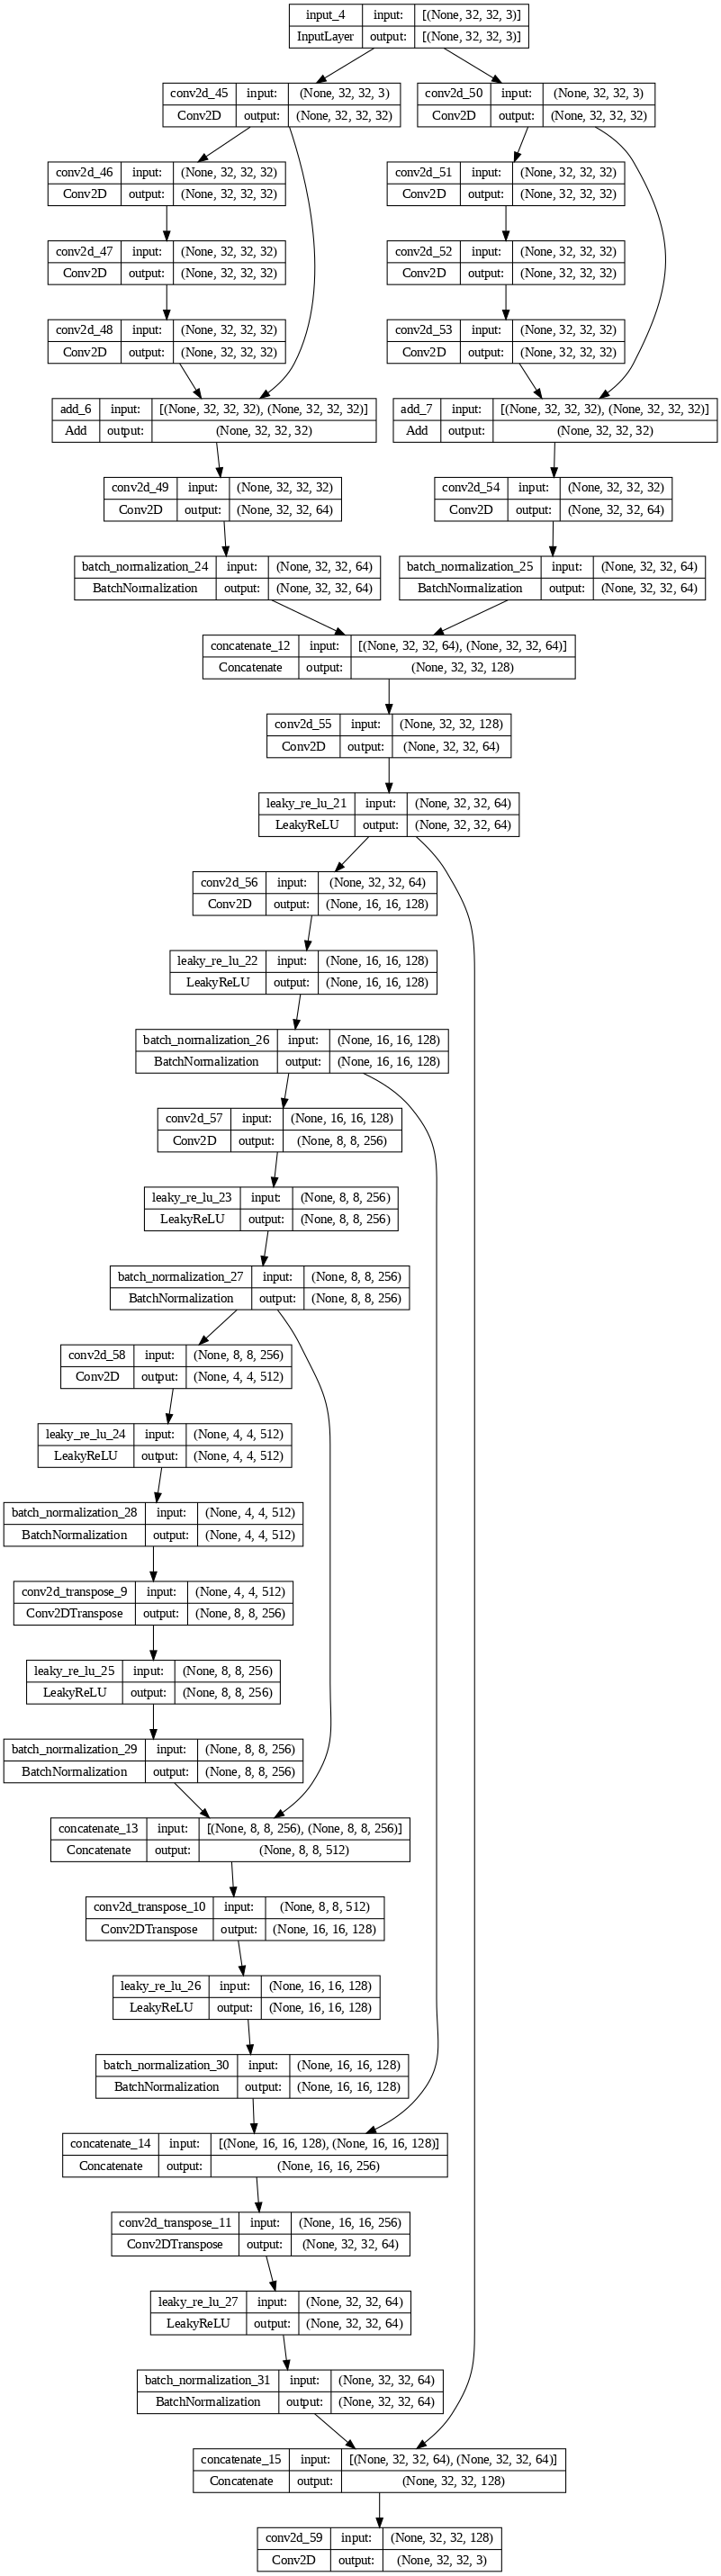

In [22]:
model = autoencoder((32,32,3))

tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [ ]:
model.summary()

In [23]:
stop_training = callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=5, restore_best_weights=True)
reduce_learning_rate = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6, min_lr=0.000001)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics='accuracy')

In [25]:
model.fit(x=masked_x_train, y=x_train, validation_split=0.1, batch_size=32, epochs=100, verbose=1, shuffle=True, callbacks=[stop_training, reduce_learning_rate])


Epoch 1/100
1407/1407 [==============================] - 80s 50ms/step - loss: 0.0109 - accuracy: 0.7517 - val_loss: 0.0096 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 70s 49ms/step - loss: 0.0096 - accuracy: 0.7908 - val_loss: 0.0105 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 70s 50ms/step - loss: 0.0092 - accuracy: 0.8012 - val_loss: 0.0116 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 69s 49ms/step - loss: 0.0090 - accuracy: 0.8073 - val_loss: 0.0087 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 69s 49ms/step - loss: 0.0087 - accuracy: 0.8145 - val_loss: 0.0087 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 70s 50ms/step - loss: 0.0085 - accuracy: 0.8190 - val_loss: 0.0083 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 7/100
1407/1407 [=================

In [26]:
predictions = model.predict(x=masked_x_test, verbose=0)

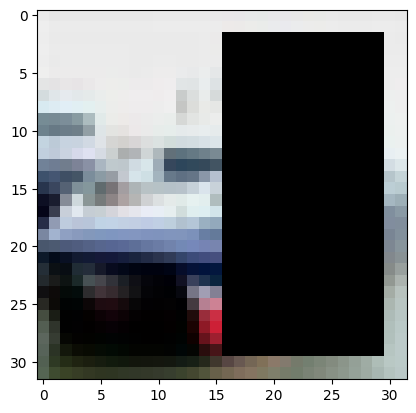

In [27]:
plt.imshow(masked_x_test[1])
plt.show()

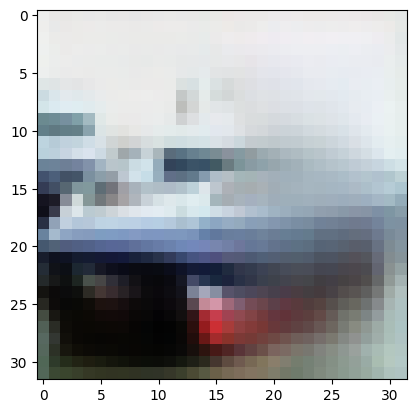

In [28]:
plt.imshow(predictions[1])
plt.show()

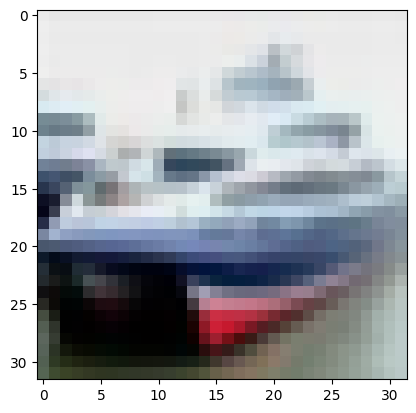

In [29]:
plt.imshow(x_test[1])
plt.show()

In [15]:
from keras import backend as K
# calculate the MSE between the predictions and ground truth
mse = K.mean(K.square(x_test - predictions))
# evaluate the model
print('Mean Squared Error:', K.eval(mse))

Mean Squared Error: 0.008250367


In [30]:
mse = np.mean(np.square(predictions - x_test),axis=1)
print(mse.shape)
print("The mse on the test set is : ",np.mean(mse), " +/- ",np.std(mse))

(10000, 32, 3)
The mse on the test set is :  0.008207888  +/-  0.015632764
